# Use multiple GPU

In [1]:
import tensorflow as tf

# Define tand get the number os devices. 
strategy = tf.distribute.MirroredStrategy()
print('DEVICES AVAILABLE: {}'.format(strategy.num_replicas_in_sync))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

DEVICES AVAILABLE: 2


In [2]:
# To have reproducible results and compare them
import numpy as np 

RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Define Dataset

In [3]:
import os
import re
import pandas as pd

desc = {
    '0' : '0 - No DR',
    '1' : '1 - Mild',
    '2' : '2 - Moderate',
    '3' : '3 - Severe',
    '4' : '4 - Proliferative DR'
}

def define_paths(dir):

    files_path = []
    classes = []
    folders = os.listdir(dir)
    for folder in folders:
        folder_path = os.path.join(dir, folder)
        file_list = os.listdir(folder_path)
        for file_name in file_list:
            fpath = os.path.join(folder_path, file_name)
            # append to the list
            files_path.append(fpath)
            classes.append(desc[folder])

    return files_path, classes

def define_df(files, classes):
    file_series = pd.Series(files, name= 'file_paths')
    class_series = pd.Series(classes, name='class')
    return pd.concat([file_series, class_series,], axis= 1)

def make_df_from_dir(dir):
    files, classes = define_paths(dir)
    df = define_df(files, classes)
    return df

def make_df_from_csv(file_path, dir):
    df = pd.read_csv(file_path)
    df.columns = ['file_paths', 'class']
    df['file_paths'] = dir + df['file_paths'].astype(str) + '.png'
    df['class'] = df['class'].map(str).map(desc)
    return df
    
    

In [4]:
train_dir = '/kaggle/input/diabetic-retinopathy-resized-arranged/'
val_dir = '/kaggle/input/aptos2019-blindness-detection/train_images/'
val_csv_path = '/kaggle/input/aptos2019-blindness-detection/train.csv'
train_df = make_df_from_dir(train_dir)
val_df = make_df_from_csv(val_csv_path, val_dir)

In [5]:
# shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35126, 2)
(3662, 2)


In [6]:
train_df

file_paths                 class
0      /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
1      /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
2      /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
3      /kaggle/input/diabetic-retinopathy-resized-arr...  4 - Proliferative DR
4      /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
...                                                  ...                   ...
35121  /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
35122  /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
35123  /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
35124  /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR
35125  /kaggle/input/diabetic-retinopathy-resized-arr...             0 - No DR

[35126 rows x 2 columns]

In [7]:
val_df

file_paths         class
0     /kaggle/input/aptos2019-blindness-detection/tr...     0 - No DR
1     /kaggle/input/aptos2019-blindness-detection/tr...  2 - Moderate
2     /kaggle/input/aptos2019-blindness-detection/tr...      1 - Mild
3     /kaggle/input/aptos2019-blindness-detection/tr...     0 - No DR
4     /kaggle/input/aptos2019-blindness-detection/tr...     0 - No DR
...                                                 ...           ...
3657  /kaggle/input/aptos2019-blindness-detection/tr...  2 - Moderate
3658  /kaggle/input/aptos2019-blindness-detection/tr...     0 - No DR
3659  /kaggle/input/aptos2019-blindness-detection/tr...  2 - Moderate
3660  /kaggle/input/aptos2019-blindness-detection/tr...     0 - No DR
3661  /kaggle/input/aptos2019-blindness-detection/tr...     0 - No DR

[3662 rows x 2 columns]

# Exploratory Data Analysis (EDA)

In [8]:
def plot(df, column, title):
    count = df[column].value_counts()
    percent = 100*df[column].value_counts(normalize=True)
    df = pd.DataFrame({'Sample count':count, 'Percentage':percent.round(1)})
    print(df)
    count.plot(kind='bar', title=title)


                      Sample count  Percentage
0 - No DR                    25810        73.5
2 - Moderate                  5292        15.1
1 - Mild                      2443         7.0
3 - Severe                     873         2.5
4 - Proliferative DR           708         2.0


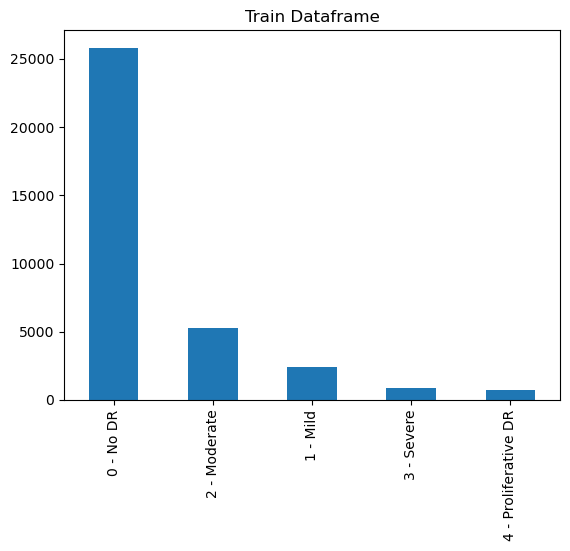

In [9]:
plot(train_df, 'class', 'Train Dataframe')

                      Sample count  Percentage
0 - No DR                     1805        49.3
2 - Moderate                   999        27.3
1 - Mild                       370        10.1
4 - Proliferative DR           295         8.1
3 - Severe                     193         5.3


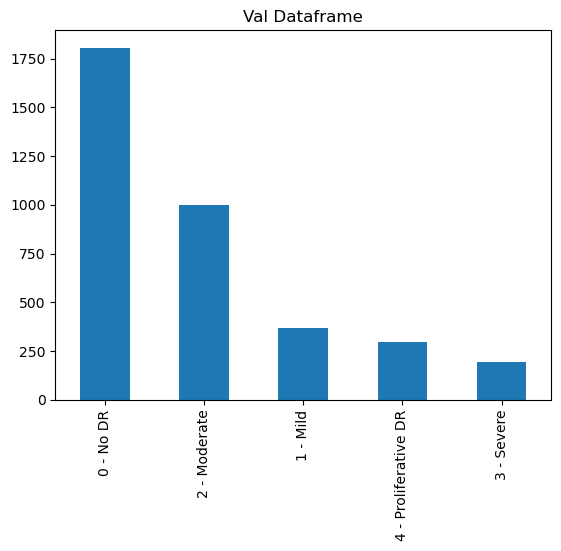

In [10]:
plot(val_df, 'class', 'Val Dataframe')

# Preprocess images

In [11]:
# import cv2

# def add_weighted(image, alpha, gaussian_blur_image, beta, gamma):
#     weighted_sum = tf.add(tf.multiply(image, alpha), tf.multiply(gaussian_blur_image, beta))
#     result = tf.add(weighted_sum, gamma)
#     return result


In [12]:
def preprocess_images(img):
    img = tf.image.adjust_contrast(img, 0.7)
    img = tf.image.adjust_brightness(img, 0.3)
    img = tf.image.rgb_to_grayscale(img)
    img = tf.image.resize(img, [350, 350])   
#     gaussian_blur_image = cv2.GaussianBlur(img.numpy(), (0, 0), 350/40)
#     gaussian_blur_tensor = tf.convert_to_tensor(gaussian_blur_image)
#     img = add_weighted(img, 4, gaussian_blur_tensor, -4, 128)
    return img

In [13]:
IMAGE_SIZE = 350
BATCH_SIZE_PER_REPLICA = 64
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

# Image Data Generator

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    preprocessing_function = preprocess_images
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    preprocessing_function = preprocess_images
)

In [15]:
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
    class_mode='categorical')

val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col= 'file_paths',
    y_col= 'class',
    target_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
    shuffle=False,
    class_mode='categorical')


Found 35126 validated image filenames belonging to 5 classes.
Found 3662 validated image filenames belonging to 5 classes.


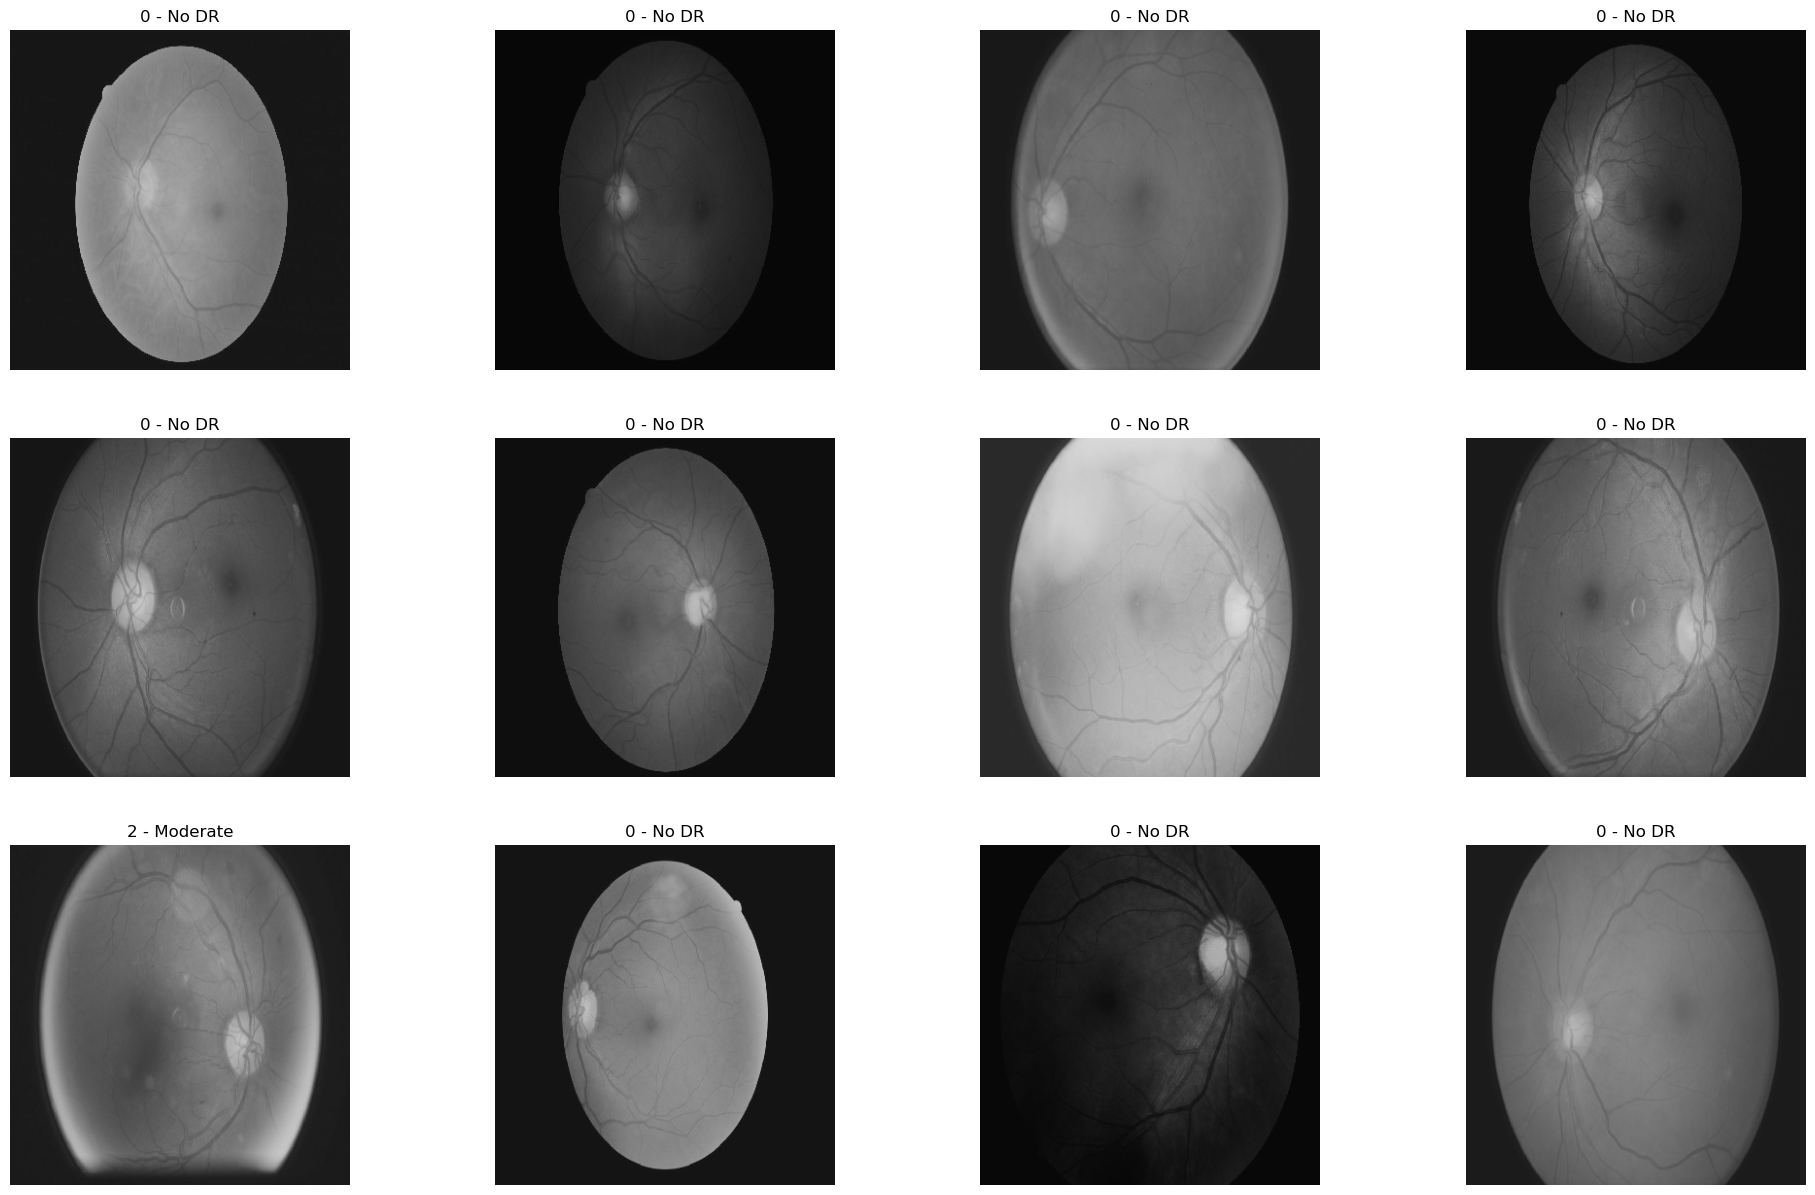

In [16]:
# images after augmentation
import matplotlib.pyplot as plt  
import random

def display_samples(generator, columns=4, rows=3):
    images, labels = next(generator)
    class_list = list(generator.class_indices.keys())
    fig = plt.figure(figsize=(6*columns, 5*rows))
    for i in range (columns*rows):
        fig.add_subplot(rows, columns, i+1)
        image = images[i]
        index = np.argmax(labels[i])
        class_name = class_list[index]
        plt.title(class_name)
        plt.imshow(image)
        plt.axis('off')
        
display_samples(train_generator)


# Model Architecture

In [17]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

with strategy.scope():
    base_model = DenseNet121(include_top= False, weights= "imagenet", input_shape= (IMAGE_SIZE,IMAGE_SIZE,3))
    base_model.trainable = False
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation= 'relu'),
        tf.keras.layers.Dropout(0.6),
        tf.keras.layers.Dense(64, activation= 'relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

model.summary()

29084464/29084464 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 11, 11, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0 

In [18]:
from keras.optimizers import Adam
model.compile(optimizer= Adam(), loss= 'categorical_crossentropy', metrics= ['accuracy'])


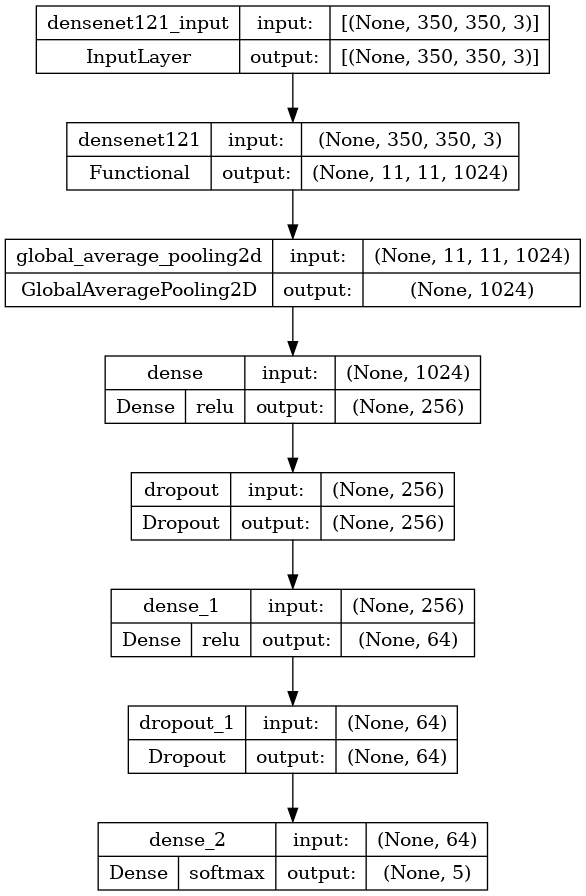

In [19]:
model_img_file = 'model.png'
tf.keras.utils.plot_model(model, to_file=model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_layer_names=True )

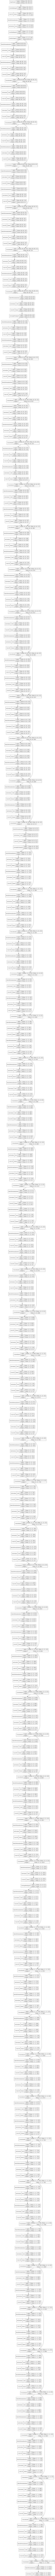

In [20]:
base_model_img_file = 'base_model.png'
tf.keras.utils.plot_model(base_model, to_file=base_model_img_file, 
                          show_shapes=True, 
                          show_layer_activations=True, 
                          show_layer_names=False )

In [21]:
epochs = 20
history = model.fit(
    x = train_generator, 
    validation_data = val_generator,
    epochs = epochs, 
    verbose = 1, 
    shuffle = False
)

Epoch 1/20
275/275 [==============================] - 1438s 5s/step - loss: 0.9359 - accuracy: 0.7232 - val_loss: 1.1970 - val_accuracy: 0.4929
Epoch 2/20
275/275 [==============================] - 1216s 4s/step - loss: 0.8617 - accuracy: 0.7346 - val_loss: 1.2028 - val_accuracy: 0.4929
Epoch 3/20
275/275 [==============================] - 1199s 4s/step - loss: 0.8368 - accuracy: 0.7347 - val_loss: 1.2256 - val_accuracy: 0.4929
Epoch 4/20
275/275 [==============================] - 1121s 4s/step - loss: 0.8245 - accuracy: 0.7352 - val_loss: 1.1985 - val_accuracy: 0.4929
Epoch 5/20
275/275 [==============================] - 1164s 4s/step - loss: 0.8219 - accuracy: 0.7350 - val_loss: 1.1838 - val_accuracy: 0.4929
Epoch 6/20
275/275 [==============================] - 1172s 4s/step - loss: 0.8180 - accuracy: 0.7357 - val_loss: 1.2050 - val_accuracy: 0.4929
Epoch 7/20
275/275 [==============================] - 1182s 4s/step - loss: 0.8158 - accuracy: 0.7353 - val_loss: 1.2048 - val_accuracy:

# Plot Accuracy and Loss

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    Epochs = [i+1 for i in range(len(acc))]
    
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, loss, label= 'Training loss')
    plt.plot(Epochs, val_loss, label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label) 
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout
    plt.show()

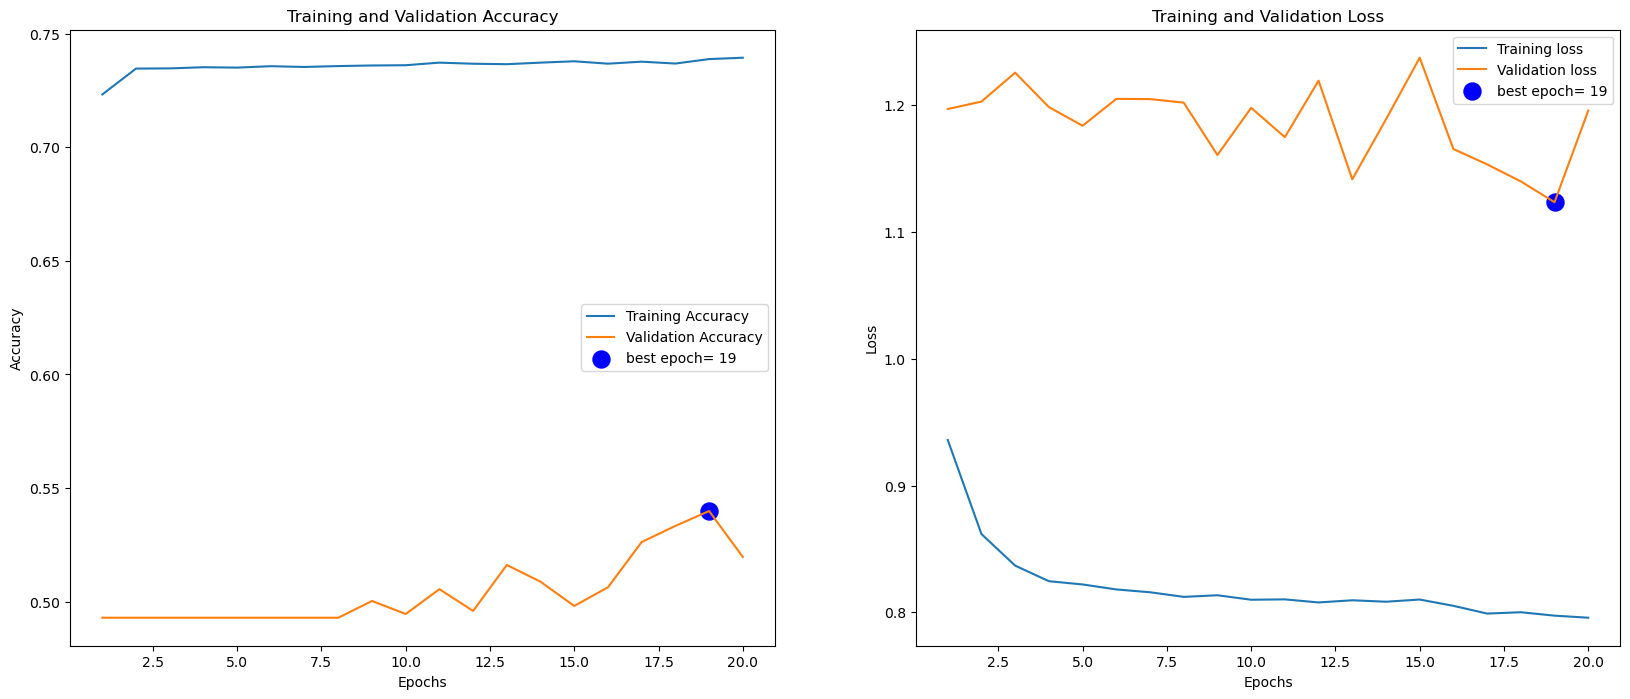

In [23]:
plot_training(history)


# Fine Tuning 

In [24]:
model.layers[0].trainable = True
model.summary()

model.compile(
    optimizer=Adam(1e-5),  # Low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 11, 11, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

In [25]:
fine_tune_epoch = 20

total_epochs =  epochs + fine_tune_epoch

history_model_fine = model.fit(x=train_generator,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_generator)

Epoch 20/40


ResourceExhaustedError: Graph execution error:

Detected at node 'replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D'
Detected at node 'replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D'
Detected at node 'replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D' defined at (most recent call last):
    File "/opt/conda/lib/python3.10/threading.py", line 973, in _bootstrap
      self._bootstrap_inner()
    File "/opt/conda/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
      self.run()
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/sequential.py", line 412, in call
      return super().call(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/training.py", line 558, in __call__
      return super().__call__(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1145, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 290, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/opt/conda/lib/python3.10/site-packages/keras/layers/convolutional/base_conv.py", line 262, in convolution_op
      return tf.nn.convolution(
Node: 'replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D'
3 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[64,128,44,44] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[div_no_nan_1/ReadVariableOp_1/_566]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[div_no_nan/AddN_1/_578]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[64,128,44,44] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[div_no_nan_1/ReadVariableOp_1/_566]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (2) RESOURCE_EXHAUSTED:  OOM when allocating tensor with shape[64,128,44,44] and type float on /job:localhost/replica:0/task:0/device:GPU:1 by allocator GPU_1_bfc
	 [[{{node replica_1/sequential/densenet121/conv3_block12_1_conv/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_20328944]

# Plot 

In [ ]:
plt.figure(figsize= (18, 25))

plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], label= 'Training Accuracy')
plt.plot(history.history['val_accuracy'], label= 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylim([0, 1.0])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 3)
plt.plot(history.history['loss'], label= 'Training Loss')
plt.plot(history.history['val_loss'], label= 'Validation Loss')
# plt.ylim([0, 3.0])
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history_model_fine.history['accuracy'], label= 'Training Accuracy')
plt.plot(history_model_fine.history['val_accuracy'], label= 'Validation Accuracy')
plt.ylim([0, 1.0])
plt.title('Training and Validation Accuracy Fine Tune')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')

plt.subplot(2, 2, 4)
plt.plot(history_model_fine.history['loss'], label= 'Training Loss')
plt.plot(history_model_fine.history['val_loss'], label= 'Validation Loss')
# plt.ylim([0, 3.0])
plt.title('Training and Validation Loss Fine Tune')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper right')

plt.tight_layout
plt.show()

# View Confussion Matrix

In [ ]:
preds = model.predict(val_generator)
y_pred = [np.argmax(y) for y in preds]
print(y_pred)

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def make_evaluation(generator, y_pred):
    classes = list(generator.class_indices.keys())
    class_count = len(classes)
    cm = confusion_matrix(generator.classes, y_pred)

    plt.figure(figsize=(12, 8))
    sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)     
    plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
    plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    print("\nClassification Report:\n----------------------")
    print(classification_report(generator.classes, y_pred, target_names=classes))

make_evaluation(val_generator, y_pred)

# Save the model

In [ ]:
model.save("model_dr.h5")

In [ ]:
import pickle

pickle.dump(model, open('model_dr.pkl', 'wb'))